### uses env timeseriesai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tsai.all import *
from joblib import Parallel, delayed

In [119]:
data_root = '/media/scottcha/E1/Data/OAPMLData/'
#data_root = '/media/scottcha/E1/Data/Temp/Tutorial/'
ml_path = data_root + '/5.MLData/'
num_features = 978
interpolation = 1
label = 'WindSlab_Likelihood'
file_label = 'co_WindSlab_Likelihood_small'

In [120]:
def calculate_feature_mean(feature):
    print('On feature: ' + str(feature))
    return np.nanmean(X[0:1000,feature,:])

In [121]:
def calculate_feature_std(feature):
    print('On feature: ' + str(feature))
    return np.nanstd(X[0:1000,feature,:])

In [122]:
#load the X train data from numpy as memmapped file
X = np.load(ml_path + '/Xtrain_batch_0_' + file_label + '_on_disk.npy', mmap_mode='r')

In [123]:
means_fn = ml_path + '/feature_means_interpolation' + str(interpolation) + '_' + file_label + 'x.npy'
std_fn = ml_path + '/feature_std_interpolation' + str(interpolation)  + '_' + file_label +   'x.npy'

In [124]:
#if we don't have cached versions of these we need to calcualte this for the feature
#standardization, this takes awhile and requires a lot of memory so I only do it on a subset
#of the data (first 100000 rows)
feature_means = Parallel(n_jobs=4)(map(delayed(calculate_feature_mean), range(0,num_features)))

In [125]:
feature_means[:10]

[8.411644e-05,
 0.00012227037,
 4.6389112e-05,
 9.6683776e-05,
 0.00011173538,
 8.2050545e-05,
 9.710054e-05,
 0.00010626839,
 8.8397304e-05,
 0.000101834776]

In [126]:
feature_std = Parallel(n_jobs=4)(map(delayed(calculate_feature_std), range(0,num_features)))

In [127]:
feature_std[:10]

[4.2914737e-05,
 5.4353375e-05,
 5.259895e-05,
 1.8726983e-05,
 2.1738906e-05,
 1.9990566e-05,
 2.1269607e-05,
 2.2244025e-05,
 2.2745468e-05,
 2.841976e-05]

In [9]:
#cache the values
#np.save(ml_path + '/feature_means_interpolation' + str(interpolation) +  'x.npy', np.asarray(feature_means))

In [10]:
#np.save(ml_path + '/feature_std_interpolation' + str(interpolation) +  'x.npy', np.asarray(feature_std))

In [175]:
#load the values
X = np.load(ml_path + '/X_all_' + file_label + '.npy', mmap_mode='r')

In [129]:
#read in the corresponding label files and concat them
#can get the right values here based on the contents of hte ml_path directory
num_y_batches = 1
num_y_train_files_per_batch = 1
num_y_test_batches = 1
num_y_test_files_per_batch = 1


y_df = None
for i in range(0, num_y_batches):
    for j in range(0, num_y_train_files_per_batch):
        df = pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '.parquet')  
        y_df = pd.concat([y_df, df])

for i in range(0, num_y_test_batches):
    for j in range(0, num_y_test_files_per_batch):
        df = pd.read_parquet(ml_path + '/y_test_batch_' + str(i) + '_' + file_label  + '.parquet')  
        y_df = pd.concat([y_df, df])

In [130]:
y_df[y_df['season']!='18-19'][label].value_counts()

2-likely         1429
1-possible       1428
no-data          1424
0-unlikely        648
3-very likely      71
Name: WindSlab_Likelihood, dtype: int64

In [131]:
y_df['season'].value_counts()

17-18    1991
15-16    1665
16-17    1344
18-19    1000
Name: season, dtype: int64

In [132]:
y_df.shape

(6000, 302)

In [133]:
X.shape

(6000, 978, 180)

In [134]:
y_df[label].value_counts()

2-likely         1763
1-possible       1760
no-data          1758
0-unlikely        648
3-very likely      71
Name: WindSlab_Likelihood, dtype: int64

In [135]:
y_df[y_df['season']=='18-19'][label].value_counts()

no-data       334
2-likely      334
1-possible    332
Name: WindSlab_Likelihood, dtype: int64

In [205]:
#convert the labels to encoded values
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['no-data', '0-unlikely', '1-possible', '2-likely', '3-very likely'], ordered=True)
y_df[label + '_cat'] = y_df[label].astype(cat_type)
y = y_df[label + '_cat'].cat.codes.values
dict( enumerate(y_df[label + '_cat'].cat.categories ) )

{0: 'no-data',
 1: '0-unlikely',
 2: '1-possible',
 3: '2-likely',
 4: '3-very likely'}

In [206]:
pd.Series(y).value_counts()

3    1763
2    1760
0    1758
1     648
4      71
dtype: int64

In [207]:
#index file which indicates which rows in X are train or test
#be carful these don't overlap
train_test_split = 5000
#can use a smaller train subset to make development faster
splits_2 = (L([i for i in range(0,train_test_split)]).shuffle(), L([i for i in range(train_test_split,train_test_split+1000)]).shuffle())

In [208]:
splits_2

((#5000) [2828,1075,759,4571,683,3436,3606,4868,1783,153...],
 (#1000) [5519,5298,5878,5581,5224,5251,5625,5691,5752,5753...])

In [209]:
#load and check the means and std deviations
feature_means = (np.nan_to_num(feature_means))

In [210]:
np.isnan(feature_means).any()

False

In [211]:
feature_std = (np.nan_to_num(feature_std, nan=1.0))

In [212]:
np.isnan(feature_std).any()

False

In [213]:
#method to standardize each batch while also replacing any nans with the mean value before standarization
class TSStandardizeNanMeanReplaceNan(Transform):
    "Standardize/destd batch of `NumpyTensor` or `TSTensor`"
    parameters, order = L('mean', 'std'), 99
    def __init__(self, mean=None, std=None, by_sample=False, by_var=False, verbose=False):
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self.mean is None or self.std is None:
            pv(f'{self.__class__.__name__} setup mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}', self.verbose)
            x, *_ = dl.one_batch()
            x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            pv(f'mean: {self.mean}  std: {self.std}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)):
        fill_values = torch.zeros_like(x)
        std_values = torch.zeros_like(x)       
        for i in range(0,x.shape[1]):
            fill_values[:,i,:] = torch.full_like(x[:,i,:], feature_means[i])
            std_values[:,i,:] = torch.full_like(x[:,i,:], feature_std[i])
        
        x = torch.where(torch.isnan(x), fill_values, x)
       
        if self.by_sample:        
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            
        t = (x - fill_values) / std_values
        del fill_values, std_values
        return torch.where(torch.isnan(t), torch.zeros_like(t), t)

In [214]:
X.shape

(6000, 978, 7)

In [176]:
X = X[:, :, -7:]

In [215]:
#create the dataset
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)

In [216]:
X[0]

memmap([[7.7999997e-05, 6.3714288e-05, 6.1857143e-05, ..., 5.9571430e-05,
         6.3428575e-05, 8.4142855e-05],
        [9.6999996e-05, 7.0000002e-05, 6.5000000e-05, ..., 8.8000001e-05,
         9.2000002e-05, 9.6000003e-05],
        [6.9000002e-05, 5.9000002e-05, 5.9000002e-05, ..., 7.0000001e-06,
         4.2000000e-05, 7.4000003e-05],
        ...,
        [1.1960000e-01, 1.1960000e-01, 1.1960000e-01, ..., 1.1960000e-01,
         1.1960000e-01, 1.1960000e-01],
        [1.1960000e-01, 1.1960000e-01, 1.1960000e-01, ..., 1.1960000e-01,
         1.1960000e-01, 1.1960000e-01],
        [1.1960000e-01, 1.1960000e-01, 1.1960000e-01, ..., 1.1960000e-01,
         1.1960000e-01, 1.1960000e-01]], dtype=float32)

<AxesSubplot:title={'center':'3'}>

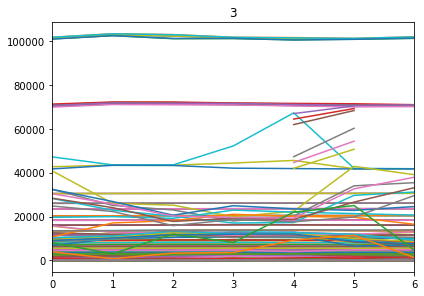

In [217]:
#check on set
show_at(dsets.valid, 6)

In [218]:
#create the dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardizeNanMeanReplaceNan()], num_workers=0)

In [219]:
#check both the train and test sets to ensure that there aren't full rows with all nulls

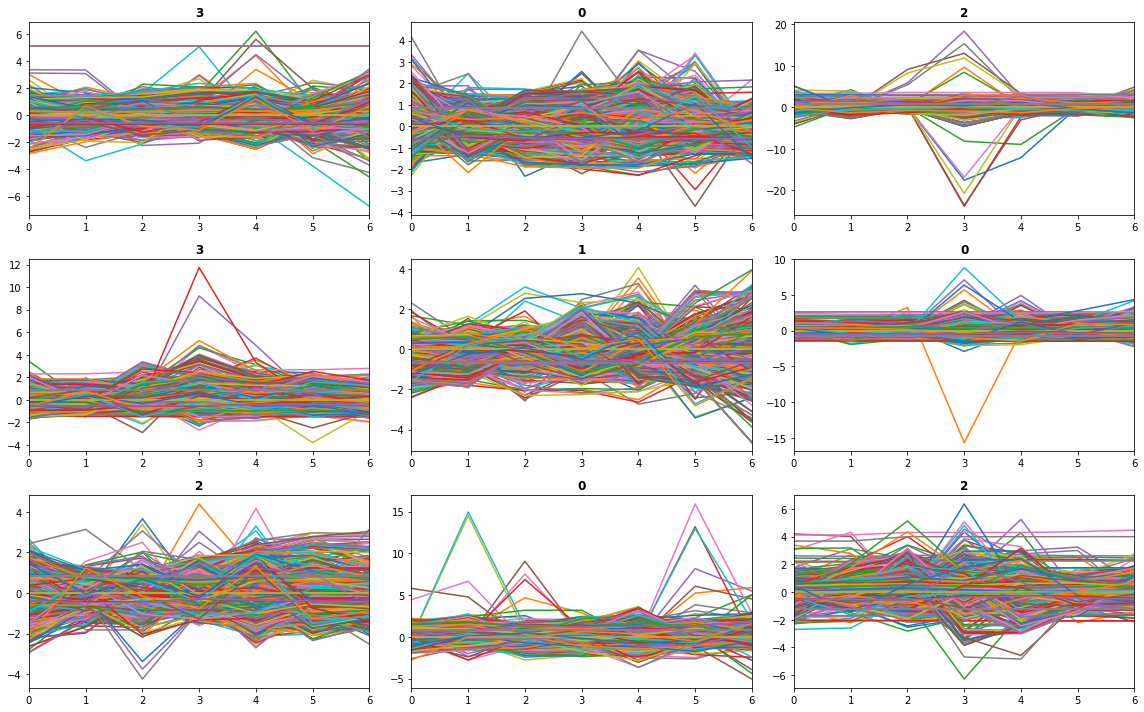

In [220]:
dls.show_batch()

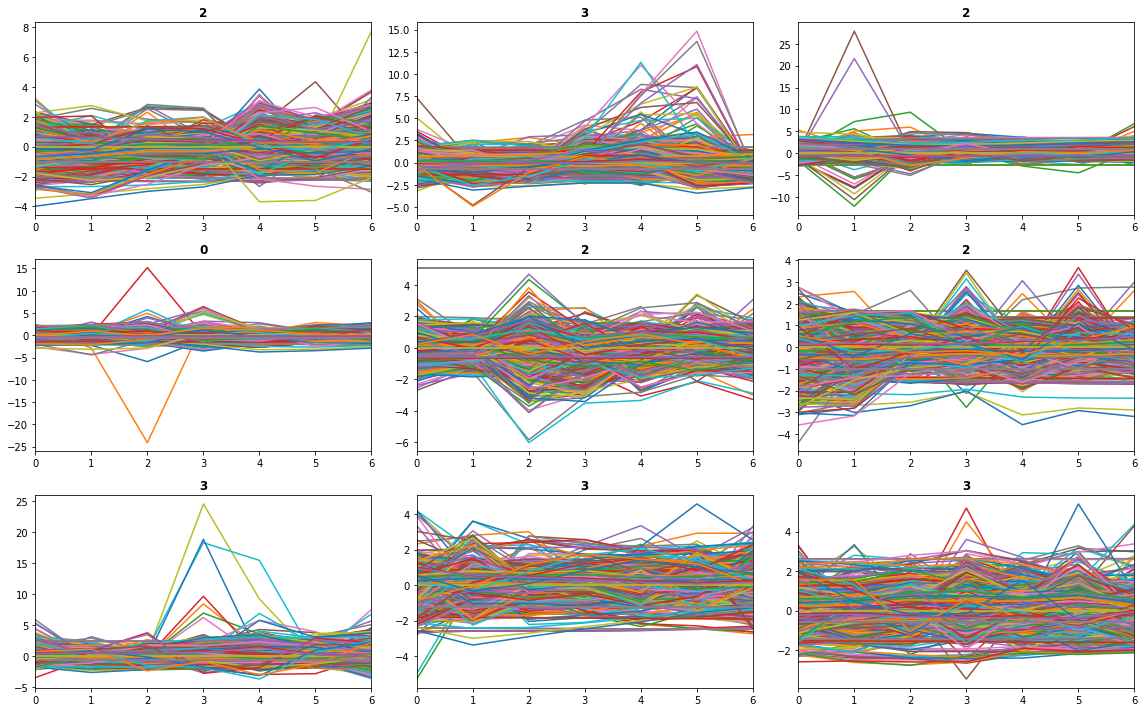

In [221]:
dls.valid.show_batch()

In [222]:
dls.c

5

In [223]:
dls.vars

978

# Lets try and train a model, in the tutorial case we are using an extremely small dataset so no conclusions should be drawn from these results they are for illustrative purposes only

In [224]:
dls.valid.c

3

In [230]:
model = InceptionTime(dls.vars, dls.c)
matcor = MatthewsCorrCoef()

#learn = Learner(dls, model, metrics=[matcor, accuracy])
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

Path('models/stage0.pth')

/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0014454397605732083)

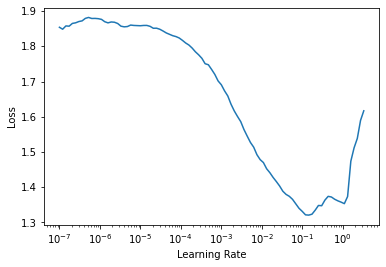

In [189]:
learn.load('stage0')
learn.lr_find()

In [63]:
#learn.fit(n_epoch=10, lr=1e-2)

In [231]:
#can use this once overfitting is resolved
learn.fit_one_cycle(2, lr_max=1e-2)
#learn.save('stage1')

epoch,train_loss,valid_loss,accuracy,time
0,0.879071,1.218424,0.474000,00:21
1,0.626084,1.175385,0.495000,00:21


### Results
1. looking at the metrics above it seems to be overfitting after epoch 1
2. Looking at the confusion matrix we can see that its ok at distinquishing between 0/1 & 2/3 

Possibilities:
2. There may be features which are causing the overfitting


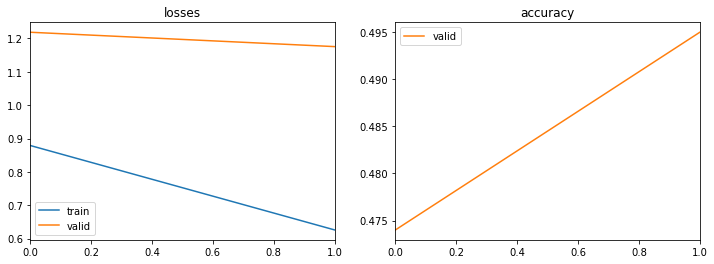

In [232]:
#only works with more than one epoch
learn.recorder.plot_metrics()

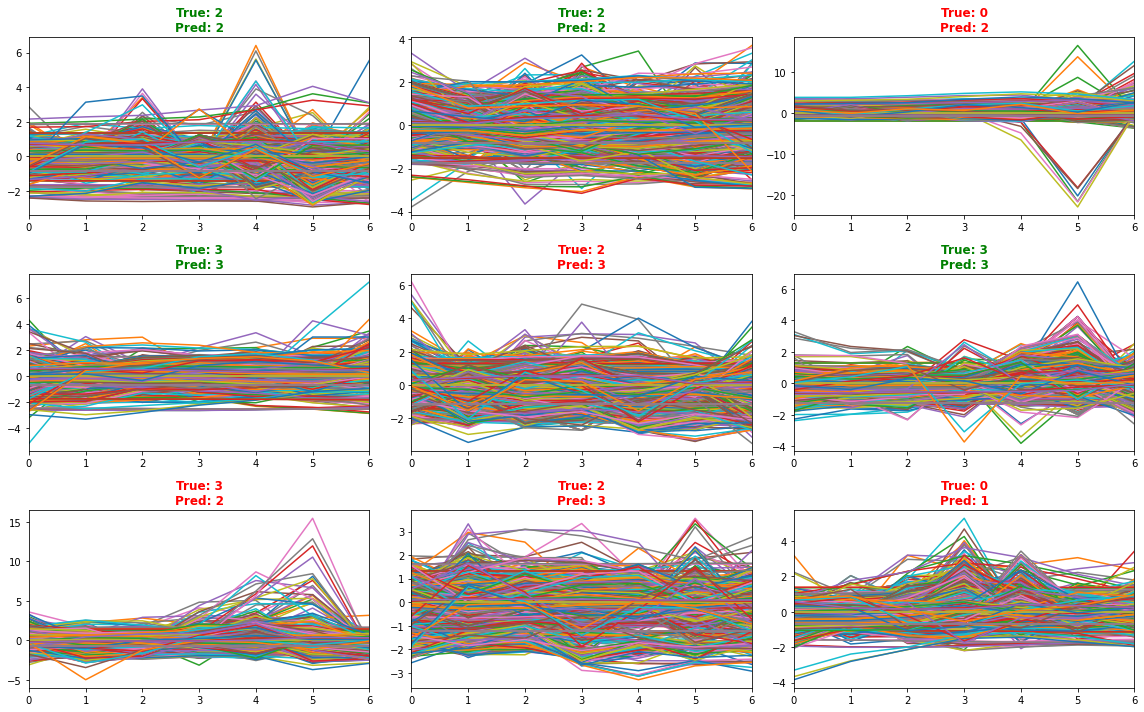

In [233]:
learn.show_results()

/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/fastai/interpret.py:71: RuntimeWarning: invalid value encountered in true_divide
  if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


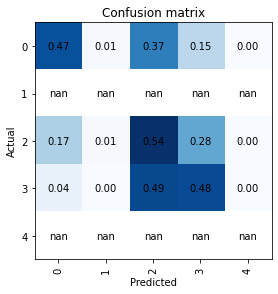

In [235]:
 
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)